# Определение перспективного тарифа для телеком компании

Телеком компания предлагает клиентам два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Нам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

In [1]:
import pandas as pd
import numpy as np

In [12]:
# импортируем таблички с данными
calls = pd.read_csv('calls.csv')
internet = pd.read_csv('internet.csv')
messages = pd.read_csv('messages.csv')
tariffs = pd.read_csv('tariffs.csv')
users = pd.read_csv('users.csv')

calls = calls.drop(columns=['Unnamed: 0'])
internet = internet.drop(columns=['Unnamed: 0'])
messages = messages.drop(columns=['Unnamed: 0'])
tariffs = tariffs.drop(columns=['Unnamed: 0'])
users = users.drop(columns=['Unnamed: 0'])

In [13]:
#посмотрим общую инфу по всем табличкам (по очереди)
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Мы убедились что в таблицах со звонками, сообщениями и интернетом нет пропусков ( всего  202607 звонков, 149396 интернет сессий и 123036 сообщений). В данных с тарифами тоже нет пропущенных значений. В таблице с пользователями есть отсутствующие данные в колонки churn-date (т.е. дата отказа пользователя от услег/тарифа). Оставим пока, не будем заполнять, скорее всего, этот столбец не будем использоваться.
Единственное, что надо сделать это превести дааты в нужный формат, а фактически из низ надло вытянуть месяц.

In [14]:
#посмотрим на описание всех табличек (по очереди)
calls.describe()

calls.query('duration == 0').count()

id           39613
call_date    39613
duration     39613
user_id      39613
dtype: int64

Больших выбросов в данных нет:
- звонки длятся от 0 до 38 мин (средний 6,76 минут)
- трафика тратится от 0 до 1724 мбайт за сессию (среднее 370 мбайт)

Однако очень много звонков с длительностью 0. Около 20%. Исключим их из рассмотрения. Они не дадут никакого вклада в оценку затрат пользователя, однако могут плохо сказаться на определении средних величин, например, средней продолжительности звонка.

In [15]:
calls = calls.query('duration > 0')

## Собираем рабочую таблицу

Таблица для дальнейшего анализа должна содержать следующее:
- идентификатор пользователя
- название тарифного плана
- город
- месяц
- количество минут
- количество смс
- количество мегабайт интернета

In [16]:
calls['month'] = pd.DatetimeIndex(pd.to_datetime(calls['call_date'], format='%Y-%m-%d')).month
messages['month'] = pd.DatetimeIndex(pd.to_datetime(messages['message_date'], format='%Y-%m-%d')).month
internet['month'] = pd.DatetimeIndex(pd.to_datetime(internet['session_date'], format='%Y-%m-%d')).month


df_users = users.drop(['first_name', 'last_name', 'age', 'reg_date', 'churn_date'], axis=1)

pivot_calls =  pd.DataFrame(pd.pivot_table(calls, values='duration', index=['user_id', 'month'],  aggfunc=np.sum).to_records())
pivot_messages = pd.pivot_table(messages, values='id', index=['user_id', 'month'], aggfunc='count')
pivot_messages.columns = ['message_count']
pivot_messages = pd.DataFrame(pivot_messages.to_records())
pivot_internet = pd.DataFrame(pd.pivot_table(internet, values='mb_used', index=['user_id', 'month'], aggfunc=np.sum).to_records())

In [17]:
result_calls = pd.merge(df_users, pivot_calls, on='user_id', how='outer')
result_calls['month'] = result_calls['month'].fillna(-1) # заполняем отсутствующие месяца условным обозначением -1
result_calls['duration'] = result_calls['duration'].fillna(0) # если нет данных то звонков 0
result_calls['month'] = result_calls['month'].astype('int64')

result_messages = pd.merge(df_users, pivot_messages, on='user_id', how='outer')
result_messages['month'] = result_messages['month'].fillna(-1) # заполняем отсутствующие месяца условным обозначением -1
result_messages['message_count'] = result_messages['message_count'].fillna(0) # если нет данных то сообщений 0
result_messages['month'] = result_messages['month'].astype('int64')
result_messages['message_count'] = result_messages['message_count'].astype('int64')

result_internet = pd.merge(df_users, pivot_internet, on='user_id', how='outer')
result_internet['month'] = result_internet['month'].fillna(-1) # заполняем отсутствующие месяца условным обозначением -1
result_internet['mb_used'] = result_internet['mb_used'].fillna(0) # если нет данных то интернета потрачено 0
result_internet['month'] = result_internet['month'].astype('int64')

result = pd.merge(pd.merge(result_calls, result_messages, on=['user_id', 'city', 'tariff', 'month'], how='outer'), result_internet, on=['user_id', 'city', 'tariff', 'month'], how='outer')
result['duration'] = result['duration'].fillna(0)
result['message_count'] = result['message_count'].fillna(0)
result['mb_used'] = result['mb_used'].fillna(0)
result['message_count'] = result['message_count'].astype('int64')
result = result.query('month != -1') # уберем данные с месяцем -1
result.head()

,user_id,city,tariff,month,duration,message_count,mb_used
0,1000,Краснодар,ultra,5,150.06,22,2253.49
1,1000,Краснодар,ultra,6,158.90,60,23233.77
2,1000,Краснодар,ultra,7,318.80,75,14003.64
3,1000,Краснодар,ultra,8,389.87,81,14055.93
4,1000,Краснодар,ultra,9,440.14,57,14568.91


Теперь мы видим сколько каждый пользователь использовал минут смс и интернета в месяц, можем посчитать затраты каждого пользователя.

## Считаем сколько потратил каждый пользователь

In [23]:
# объединим таблицу с данными о тарифе
tariffs = tariffs.rename(columns={"tariff_name": "tariff"})
result_costs = pd.merge(result, tariffs, on='tariff', how='outer')
#result_costs['calls_costs'] = 0
#result_costs['messages_costs'] = 0
#result_costs['internet_costs'] = 0

result_costs['minutes_paid'] = result_costs['duration'] - result_costs['minutes_included']
result_costs['minutes_paid'] = result_costs['minutes_paid'].astype(int)
result_costs.loc[result_costs['minutes_paid'] < 0, 'minutes_paid'] = 0
result_costs['calls_costs'] = result_costs['minutes_paid'] * result_costs['rub_per_minute']

result_costs['messages_paid'] = result_costs['message_count'] - result_costs['messages_included']
result_costs['messages_paid'] = result_costs['messages_paid'].astype(int)
result_costs.loc[result_costs['messages_paid'] < 0, 'messages_paid'] = 0
result_costs['messages_costs'] = result_costs['messages_paid'] * result_costs['rub_per_message']

result_costs['mb_paid'] = result_costs['mb_used'] - result_costs['mg_per_month_included']
result_costs['mb_paid'] = result_costs['mb_paid'].astype(int)
result_costs.loc[result_costs['mb_paid'] < 0, 'mb_paid'] = 0
result_costs['internet_costs'] = result_costs['mb_paid']  // 1024 * result_costs['rub_per_gb']
#for i in range(result_costs.shape[0]):
#    if result_costs['duration'][i] > result_costs['minutes_included'][i]:
#        result_costs['calls_costs'][i] = (result_costs['duration'][i] - result_costs['minutes_included'][i]) * result_costs['rub_per_minute'][i]
#    if result_costs['message_count'][i] > result_costs['messages_included'][i]:
#        result_costs['messages_costs'][i] = (result_costs['message_count'][i] - result_costs['messages_included'][i]) * result_costs['rub_per_message'][i]
 #   if result_costs['mb_used'][i] > result_costs['mg_per_month_included'][i]:
 #       result_costs['internet_costs'][i] = (result_costs['mb_used'][i] - result_costs['mg_per_month_included'][i]) / 1024 * result_costs['rub_per_gb'][i]
        
result_costs.head()

,user_id,city,tariff,month,duration,message_count,mb_used,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,minutes_paid,calls_costs,messages_paid,messages_costs,mb_paid,internet_costs
0,1000,Краснодар,ultra,5,150.06,22,2253.49,1000,30720,3000,1950,150,1,1,0,0,0,0,0,0
1,1000,Краснодар,ultra,6,158.90,60,23233.77,1000,30720,3000,1950,150,1,1,0,0,0,0,0,0
2,1000,Краснодар,ultra,7,318.80,75,14003.64,1000,30720,3000,1950,150,1,1,0,0,0,0,0,0
3,1000,Краснодар,ultra,8,389.87,81,14055.93,1000,30720,3000,1950,150,1,1,0,0,0,0,0,0
4,1000,Краснодар,ultra,9,440.14,57,14568.91,1000,30720,3000,1950,150,1,1,0,0,0,0,0,0


In [24]:
# количество случаев, когда пользователь выходил за рамки тарифа. Запомним....
result_costs.query('calls_costs > 0 or messages_costs > 0 or internet_costs > 0').shape[0]

1674

В 1674 случаях (это больше 50%) пользователи выходили за рамки тарифа

In [25]:
print(result_costs.query('duration==0').shape[0])
print(result_costs.query('duration==0 and message_count == 0').shape[0])

46
2


In [26]:
print(result_costs.query('mb_used==0').shape[0])
print(result_costs.query('message_count==0').shape[0])

13
497


только в 46 (1,4%) случаях поьзователи не использовали минуты разговора, в 2 (0,06%) использовали только интернет (ни звонков, ни сообщений) и в 13 (0,4%) случаях не использовали интернет. При этом в 497 (15,4%) случаях пользователь не использовал ни одного смс. Случай - это комбинация пользователя и месяца. 

In [27]:
# рассчитаем общие затраты пользователей
result_costs['total_costs'] = result_costs['rub_monthly_fee'] + result_costs['calls_costs'] + result_costs['messages_costs'] + result_costs['internet_costs']
result_costs_short = result_costs[['user_id', 'city', 'tariff', 'month', 'total_costs']]
result_costs_short.head()

,user_id,city,tariff,month,total_costs
0,1000,Краснодар,ultra,5,1950
1,1000,Краснодар,ultra,6,1950
2,1000,Краснодар,ultra,7,1950
3,1000,Краснодар,ultra,8,1950
4,1000,Краснодар,ultra,9,1950


## Строим гистограммы и ящики с усами

In [28]:
# разделим данные по тарифам и по городам
result_ultra = result_costs.query('tariff == "ultra"')
result_smart = result_costs.query('tariff == "smart"')
result_moscow = result_costs.query('city == "Москва"')
result_others = result_costs.query('city != "Москва"')

### Тариф ULTRA

In [29]:
result_ultra.describe()[['duration', 'message_count', 'mb_used']]

,duration,message_count,mb_used
count,985.000000,985.000000,985.000000
mean,497.068223,49.363452,19468.805208
std,299.904152,47.804457,10087.170752
min,0.000000,0.000000,0.000000
25%,267.750000,6.000000,11770.260000
50%,488.100000,38.000000,19308.010000
75%,711.470000,79.000000,26837.690000
max,1578.060000,224.000000,49745.690000


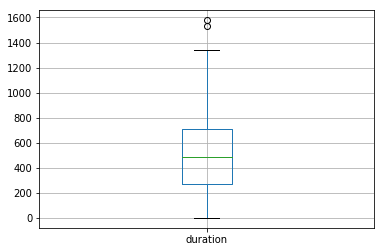

In [31]:
import matplotlib.pyplot as plt

result_ultra.boxplot(column=['duration'])

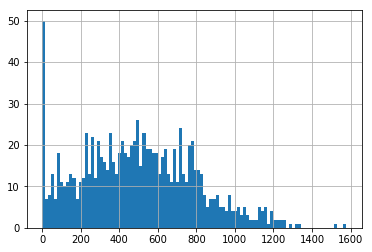

In [32]:
result_ultra['duration'].hist(bins=100)

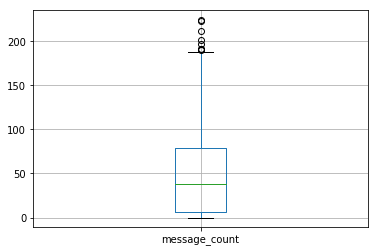

In [33]:
result_ultra.boxplot(column=['message_count'])

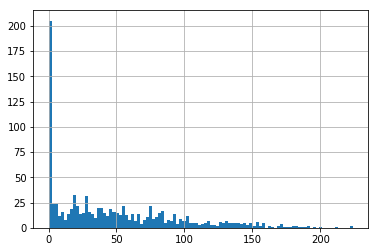

In [34]:
result_ultra['message_count'].hist(bins=100)

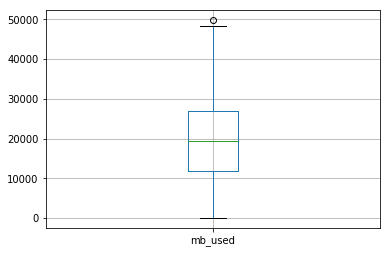

In [35]:
result_ultra.boxplot(column=['mb_used'])

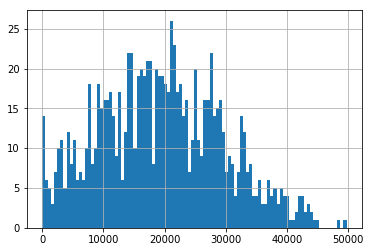

In [36]:
result_ultra['mb_used'].hist(bins=100)

### Тариф SMART

In [37]:
result_smart.describe()[['duration', 'message_count', 'mb_used']]

,duration,message_count,mb_used
count,2229.000000,2229.000000,2229.000000
mean,394.427026,33.384029,16208.386990
std,179.962207,28.227876,5870.476681
min,0.000000,0.000000,0.000000
25%,267.230000,10.000000,12643.010000
50%,397.980000,28.000000,16506.840000
75%,515.070000,51.000000,20042.930000
max,1354.220000,143.000000,38552.450000


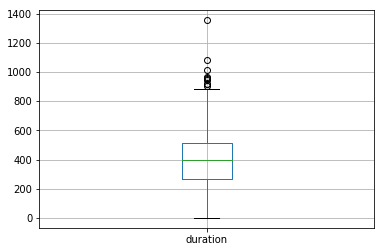

In [38]:
result_smart.boxplot(column=['duration'])

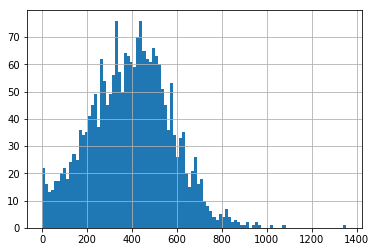

In [39]:
result_smart['duration'].hist(bins=100)

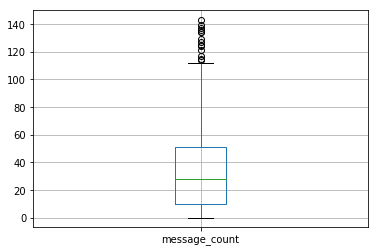

In [40]:
result_smart.boxplot(column=['message_count'])

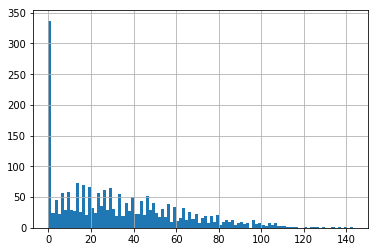

In [41]:
result_smart['message_count'].hist(bins=100)

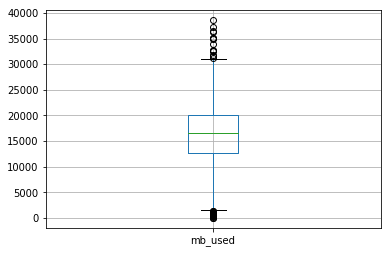

In [42]:
result_smart.boxplot(column=['mb_used'])

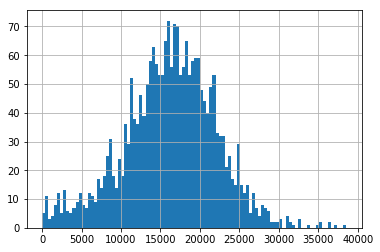

In [43]:
result_smart['mb_used'].hist(bins=100)

## Первые итоги. 

Анализ показывает предсказуемые результаты - люди все меньше звонят и обменниваются смс-сообщениями, а все больше используют интернет.

Пользователи тарифа ULTRA звонять намного мньше, чем пользователли тарифа SMART. При этом есть отдельные пользователи в каждом тарифе, которые наговари вают по 1500 минут в месяц.

СМС-ки стремительно теряют популярность большАя часть пользователей (около 15%) вообще не пользуются СМС. Даже 'любители' СМС используют максимум 143 смс-ки в месяц на тарифе SMART и максимум 224 смс-ки на тарифе ULTRA.

Использование интернета на телефонах привалирует. Меньше 0,5% случаев, когда интернет не использовался вообще в течении месяца. При этом средние показатели использования интернет-трафика для двух тарифов отличаются незначительно (SMART - 16 Гб, ULTRA - 19Гб).

Все распределения близки к нормальным. При этом для звонков и СМС мешают 0, если их отбросить, то "нормальность" распределения будет более очевидна. Самое яркое нормальное распреедление - использование интернета в тарифе SMART.

Нет больших выбросов в данных, т.к среднее значения близки к медианам.

## Проверка гипотез

### Рассмотрим первую гипотезу:
#### Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

Обозначим среднии выручки М1 и М2, тогда:

нулевая гипотеза Н0: М1=М2

альтернативная гипотеза На: М1!=М2 (двухсторонняя альтернатива)

In [44]:
# выделим выручку тарифа ULTRA и SMART
ultra_costs = result_ultra['total_costs']
smart_costs = result_smart['total_costs']

In [45]:
from scipy import stats as st

# установим уровень значимости
alpha = .05 

# выборки независимые, поэтому
hipotest = st.ttest_ind(
    ultra_costs, 
    smart_costs)

print('p-значение: ', hipotest.pvalue)

if (hipotest.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  7.544019623563157e-250
Отвергаем нулевую гипотезу


In [46]:
import scipy.stats


def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [47]:
mean_confidence_interval(ultra_costs, confidence=0.95)

(2049.746192893401, 2028.7285001121825, 2070.7638856746194)

In [48]:
mean_confidence_interval(smart_costs, confidence=0.95)

(1139.7469717362046, 1109.0531391412044, 1170.4408043312048)

### Вывод

Пользователи тарифов ULTRA и SMART обеспечивают разную выручку.
В действительности пользователи тарифа ULTRA тратят больше. В среднем пользователь тарифа ULTRA тратит 2050 руб (95% интервал [2028, 2070]). Пользователь тарифа SMART в среднем тратит 1139 руб. (95% интервал [1109, 1170])

### Рассмотрим вторую гипотезу:
#### Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Обозначим среднии выручки М1 и М2, тогда:

нулевая гипотеза Н0: М1=М2

альтернативная гипотеза На: М1!=М2 (двухсторонняя альтернатива)

In [49]:
# выделим выручку пользователей из Москвы и из других регионов
moscow_costs = result_moscow['total_costs']
others_costs = result_others['total_costs']

In [50]:
# установим уровень значимости
alpha = .05

# выборки независимые, поэтому
hipotest = st.ttest_ind(
    moscow_costs, 
    others_costs)

print('p-значение: ', hipotest.pvalue)

if (hipotest.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.3300068428693087
Не получилось отвергнуть нулевую гипотезу


In [51]:
mean_confidence_interval(moscow_costs, confidence=0.95)

(1445.8657937806875, 1387.8390148154228, 1503.892572745952)

In [52]:
mean_confidence_interval(others_costs, confidence=0.95)

(1412.2443334613906, 1382.4130923566406, 1442.0755745661406)

### Выводы

Из полученных данных нельзя сказать что выручка от пользователей из Москвы отличаетсся от выручки от пользователей из других регионов.

Действительно средние значения очень близки (1445 руб для Москвы и 1412 для регионов), и доверительные интервалы сильно перекрываются ([1387, 1503] - для Москвы и [1382, 1442] - для регионов)